In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
xr.set_options(keep_attrs=True)

## Process AMOC

Save netcdf files with the 'MOC' defined as the maximum of the total streamfunction between 500 and 2000 m depth

In [2]:
mydir = '/glade/work/lettier/NUDGE/processed/'

In [3]:
def get_moc (ds):

    ds = ds.sum(dim='moc_comp')
    ds = ds.where(ds.moc_z>500.*100.).where(ds.moc_z<=2000.*100.) # coordinate is in units of cm!
    ds = ds.max(dim='moc_z')
    return ds

In [4]:
def get_moc_ds_nudge (name):
    mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
    myfiles = sorted(os.listdir(mydir+'/moc/moccalc/'+name))
    listds = []
    for n, file in enumerate(myfiles):
        ds = xr.open_dataset(mydir+'/moc/moccalc/'+name+'/'+file)
        ds['time'] = mytime[n]
        listds.append(ds)
    ds = xr.concat(listds,dim='time')
    ds['names'] = name
    ds = ds.set_coords('names')
    
    return ds


In [5]:
mynames = [f.split('.')[0] for f in sorted(os.listdir('/glade/work/lettier/NUDGE/processed/moc/')) if '.nc' in f and 'LENS' not in f]
mynames

['anom_nudge_era',
 'anom_nudge_era',
 'anom_nudge_era_60',
 'anom_nudge_era_60',
 'anom_nudge_era_high',
 'anom_nudge_era_high',
 'anom_nudge_era_low',
 'anom_nudge_era_low',
 'nudge_era_SH_archi',
 'nudge_era_SH_archi',
 'nudge_era_high',
 'nudge_era_high']

In [6]:
for name in['nudge_era_NH_archi']:
    ds =  get_moc(get_moc_ds_nudge (name))
    ds.to_netcdf(mydir+'moc/'+name+'.moc_monthly.1979-2018.nc')

In [13]:
for name in mynames:
    ds =  get_moc(get_moc_ds_nudge (name))
    ds.to_netcdf(mydir+'moc/'+name+'.moc_monthly.1979-2018.nc')

In [ ]:
for name in ['nudge_era_high', 'anom_nudge_era', 'anom_nudge_era_low','anom_nudge_era_high']:
    ds =  get_moc(get_moc_ds_nudge (name))
    ds.to_netcdf(mydir+'moc/'+name+'.moc_monthly.1979-2018.nc')

In [ ]:
ds.MOC.attrs

In [15]:
ledir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/'
listds = []
mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')
for e in range(1,36,1):
    ens = str(e)
    if e<10:
        ens = '0'+str(e)
    print(e)
    var = 'MOC'
    myfiles = sorted([ledir+var+'/'+f for f in os.listdir(ledir+var) if ('B20TRC5CNBDRD' in f or 'BRCP85C5CNBDRD' in f) and '0'+ens+'.pop.h.'+var in f ])
    myfiles = [f for f in myfiles if '.192001-199912.nc' not in f and '208101-210012.nc' not in f]
    ds = xr.open_mfdataset(myfiles)[[var]].sel(time=slice('1979-02','2019-01'))
    ds['time'] = mytime

    ds = get_moc(ds)
    name = 'LENS'+ens
    ds['names'] = name
    ds = ds.set_coords('names')
    ds.to_netcdf(mydir+'/moc/'+name+'.moc_monthly.1979-2018.nc')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


## Get streamfunction

Plot the full streamfunction in select runs

In [5]:
mynames = ['anom_nudge_era_60','anom_nudge_era', 'nudge_era_high']

In [15]:
ds = xr.open_dataset('/glade/work/lettier/NUDGE/processed/moc/moccalc//b.e11.B20TRC5CNBDRD.f09_g16.001.pop.h.MOC.185001.nc')

In [18]:
ds.moc_components

<xarray.DataArray 'moc_components' (moc_comp: 3)>
array([b'Eulerian Mean', b'Eddy-Induced (bolus)', b'Submeso'], dtype='|S256')
Coordinates:
    time     object 1850-02-01 00:00:00
Dimensions without coordinates: moc_comp
Attributes:
    long_name:  MOC component names
    units:

In [28]:
listds = []
for name in mynames:
    ds = get_moc_ds_nudge (name)
    ds['moc_comp'] =['Eulerian Mean', 'Eddy-Induced (bolus)', 'Submeso'] 
    ds = ds.set_coords('moc_comp')
    tot = ds.sum(dim='moc_comp')
    tot['moc_comp'] = 'Total'
    tot = tot.set_coords('moc_comp')

    
    ds = xr.concat([ds,tot],dim='moc_comp')
    
    print(ds)
    ds = ds.groupby('time.year').mean(dim='time')
    ds = ds.isel(transport_reg=1)
    ds['moc_z'] = ds.moc_z/100.
    slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year,ds.load(),dim='year')
    slope.MOC.attrs = {'long_name': ' Trend in Meridional Overturning Circulation', 'units': 'Sverdrups/yr'}
    ds['MOC_trend'] = slope.MOC
    listds.append(ds)

<xarray.Dataset>
Dimensions:       (lat_aux_grid: 395, moc_comp: 4, moc_z: 61, time: 480, transport_reg: 2)
Coordinates:
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * time          (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
    names         <U17 'anom_nudge_era_60'
  * moc_comp      (moc_comp) <U20 'Eulerian Mean' ... 'Total'
Dimensions without coordinates: transport_reg
Data variables:
    MOC           (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
<xarray.Dataset>
Dimensions:       (lat_aux_grid: 395, moc_comp: 4, moc_z: 61, time: 480, transport_reg: 2)
Coordinates:
  * moc_z         (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * time          (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2018-12-31
    names         <U14 'anom_nudge_era'
  * mo

In [29]:
ds = xr.concat(listds,dim='names')

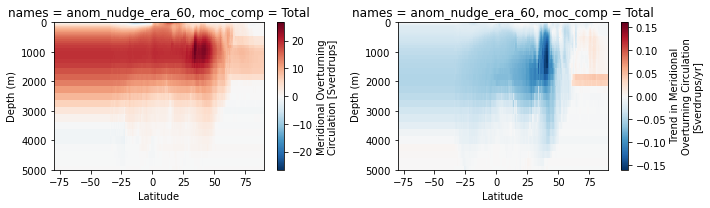

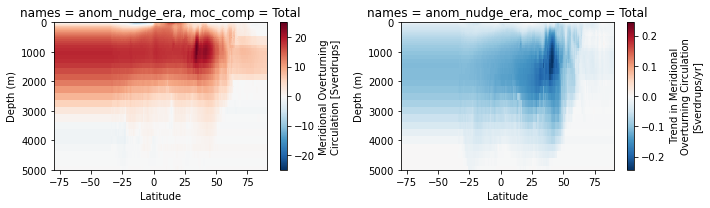

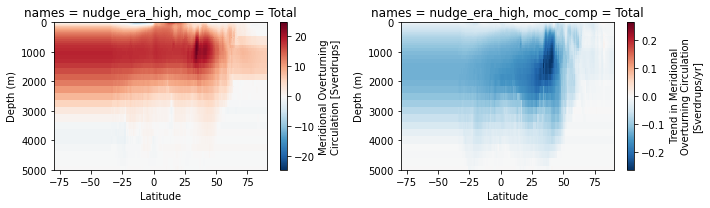

In [32]:
for name in mynames:
    fig = plt.figure(figsize=(10,3))

    ax = plt.subplot(1,2,1)
    ds.MOC.sel(moc_comp='Total').sel(names=name).mean(dim='year').plot(ax=ax)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_ylim([5000,0])

    ax = plt.subplot(1,2,2)
    ds.MOC_trend.sel(moc_comp='Total').sel(names=name).plot(ax=ax)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_ylim([5000,0])


    plt.tight_layout()
    plt.show()

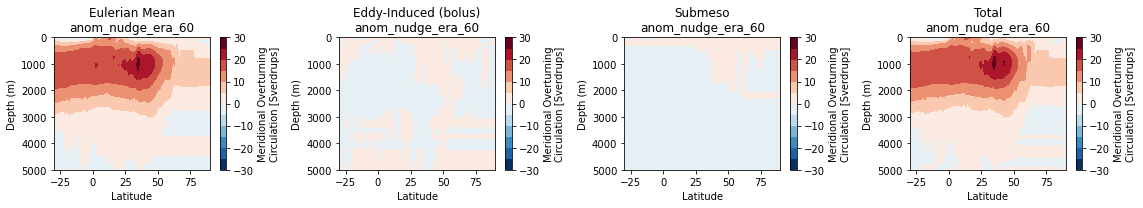

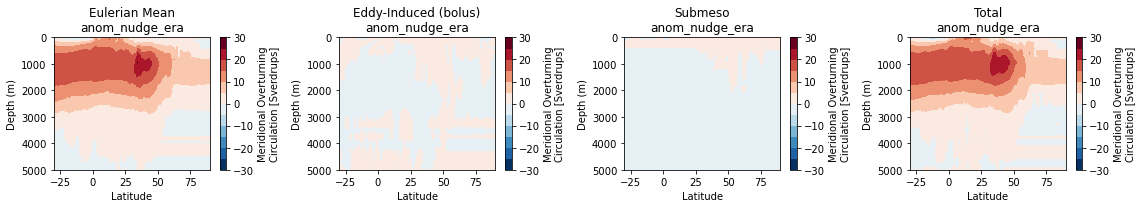

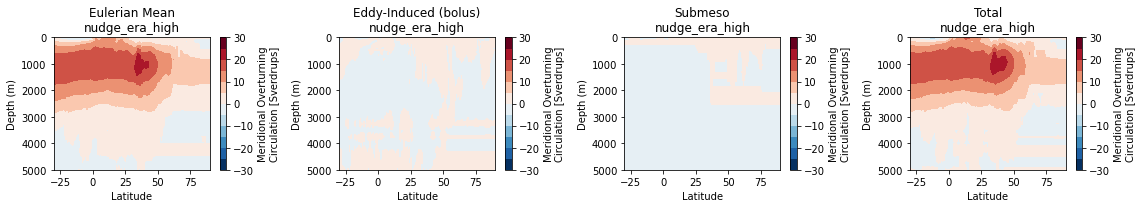

In [41]:
for name in mynames:
    fig = plt.figure(figsize=(16,3))

    for p in range(4):
        ax = plt.subplot(1,4,1+p)
        ds.MOC.isel(moc_comp=p).sel(names=name).mean(dim='year').plot.contourf(ax=ax,levels = np.arange(-30,35,5))
        ax.set_ylabel('Depth (m)')
        ax.set_xlabel('Latitude')
        ax.set_ylim([5000,0])
        ax.set_xlim([-30,90])
        ax.set_title(str(ds.isel(moc_comp=p).moc_comp.values)+'\n'+name)

    plt.tight_layout()
    plt.show()

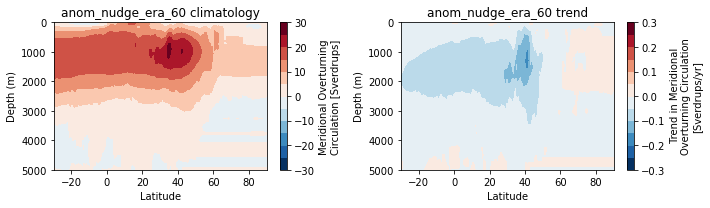

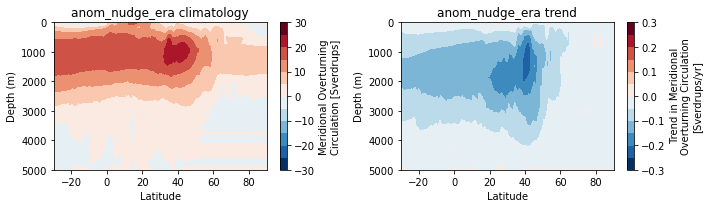

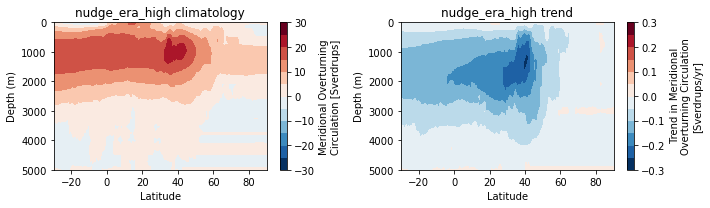

In [43]:
for name in mynames:
    fig = plt.figure(figsize=(10,3))

    ax = plt.subplot(1,2,1)
    ds.MOC.sel(moc_comp='Total').sel(names=name).mean(dim='year').plot.contourf(ax=ax,levels = np.arange(-30,35,5))
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_ylim([5000,0])
    ax.set_xlim([-30,90])
    ax.set_title(name+' climatology')



    ax = plt.subplot(1,2,2)
    ds.MOC_trend.sel(moc_comp='Total').sel(names=name).plot.contourf(ax=ax,levels = np.arange(-.3,.35,.05))
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Latitude')
    ax.set_ylim([5000,0])
    ax.set_xlim([-30,90])
    ax.set_title(name+' trend')

    plt.tight_layout()
    plt.show()

In [65]:
for name in mynames:
    mydata = ds.MOC.sel(moc_comp='Total').sel(names=name).mean(dim='year')
    mypt = mydata.where(mydata==mydata.max(),drop=True)

    print(name+' has maximum streamfunction of {0:.2f} Sv at {1:.1f}N, {2:.0f}m depth'.format(mypt.values[0][0], mypt.lat_aux_grid.values[0], mypt.moc_z.values[0]))

anom_nudge_era_60 has maximum streamfunction of 26.61 Sv at 34.6N, 928m depth
anom_nudge_era has maximum streamfunction of 24.98 Sv at 34.6N, 928m depth
nudge_era_high has maximum streamfunction of 24.67 Sv at 34.6N, 928m depth


In [63]:
for name in mynames:
    mydata = ds.MOC_trend.sel(moc_comp='Total').sel(names=name)
    mypt = mydata.where(mydata==mydata.min(),drop=True)
    print(name+' has maximum decrease in streamfunction of {0:.2f} Sv/yr at {1:.1f}N, {2:.0f}m depth'.format(mypt.values[0][0], mypt.lat_aux_grid.values[0], mypt.moc_z.values[0]))

anom_nudge_era_60 has maximum decrease in streamfunction of -0.16 Sv/yr at 41.6N, 1318m depth
anom_nudge_era has maximum decrease in streamfunction of -0.24 Sv/yr at 42.1N, 1171m depth
nudge_era_high has maximum decrease in streamfunction of -0.26 Sv/yr at 34.6N, 1483m depth


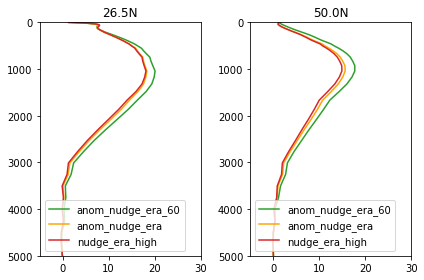

In [78]:
fig = plt.figure()

for l, lat in enumerate([26.5,50.]):
    ax = plt.subplot(1,2,1+l)
    for n, name in enumerate(mynames):
        mydata = ds.MOC.sel(moc_comp='Total').sel(names=name).mean(dim='year').interp(lat_aux_grid=lat)
        ax.plot(mydata,mydata.moc_z,label=name, c=['tab:green','orange','tab:red'][n])
        ax.set_ylim([5000,0])
        ax.set_xlim([-5,30])
        ax.legend()
        ax.set_title(str(lat)+'N')
plt.tight_layout()
plt.show()



In [83]:
dz = ds.moc_z.diff(dim='moc_z')

In [84]:
dz

<xarray.DataArray 'moc_z' (moc_z: 60)>
array([ 10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.      ,  10.      ,  10.      ,  10.      ,
        10.      ,  10.196823,  10.564468,  11.059952,  11.67807 ,
        12.424118,  13.309692,  14.35141 ,  15.571259,  16.996796,
        18.66211 ,  20.60904 ,  22.88852 ,  25.56247 ,  28.70575 ,
        32.408386,  36.77771 ,  41.940308,  48.042206,  55.24762 ,
        63.731873,  73.669495,  85.20886 ,  98.436584, 113.324646,
       129.672   , 147.05347 , 164.80713 , 182.09131 , 198.02234 ,
       211.85962 , 223.16504 , 231.86499 , 238.19434 , 242.57227 ,
       245.46777 , 247.3103  , 248.44312 , 249.11963 , 249.51343 ,
       249.73584 , 249.85938 , 249.92676 , 249.9624  , 249.98145 ],
      dtype=float32)
Coordinates:
  * moc_z    (moc_z) float32 10.0 20.0 30.0 40.0 ... 5e+03 5.25e+03 5.5e+03
Attributes:
    long_name:  depth from surface to top of layer
    units:      centimeters
    positive:   down
    valid_min:  0.0
    valid_max:  549999.06

In [85]:
vint_strm = (ds.MOC.sel(moc_comp='Total')*dz).sum(dim='moc_z')

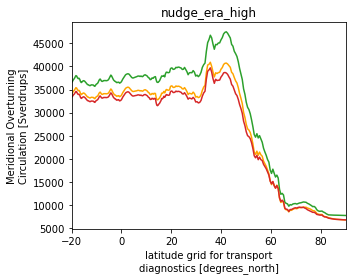

In [92]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(1,1,1)
for n, name in enumerate(mynames):
    vint_strm.sel(names=name).mean(dim='year').plot(ax=ax, c=['tab:green','orange','tab:red'][n])
    ax.set_title(name)
    ax.set_xlim([-20,90])
plt.tight_layout()
plt.show()

